In [172]:
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from sklearn import preprocessing
import seaborn as sns


import sys
sys.path.insert(0, "../scripts")
from helpers import *

## importing data

In [60]:
des_data0 = [(i,j,k) for i, j,k, in zip(["Zone Mean Air Temperature"]*3 + ["Site Outdoor Air Drybulb Temperature"] , [0,1, 2, 0], ["East Zone", "North Zone","West Zone", "Out",])]

# switching index of east and west window, some sort of error in sql??
des_data = [(i,j,k) for i, j,k, in zip(["Zone Mean Air Temperature"]*3 + ["Site Outdoor Air Drybulb Temperature"] + ["AFN Zone Ventilation Mass"]*3 + ["AFN Surface Venting Window or Door Opening Factor"]*2, [0,1, 2, 0, 0, 1, 2, 5, 1], ["East Zone", "North Zone","West Zone", "Out", "E-VentMass", "N-VentMass", "W-VentMass", "EastWindow", "WestWindow"])]

In [62]:
dir = "../rosseRoomModel/230307/test00/eplusout.sql"
t00 = LoadSQL(dir, "test00 - window var")
t00.get_valid_data(des_data);

In [61]:
dir = "../rosseRoomModel/230307/test01/eplusout.sql"
t01 = LoadSQL(dir, "test01 - window var")
t01.get_valid_data(des_data);

In [39]:
df00 = pd.DataFrame(t00.data["West Zone"].values, index=pd.to_datetime(t00.data["West Zone"].datetimes))

df01 = pd.DataFrame(t01.data["West Zone"].values, index=pd.to_datetime(t01.data["West Zone"].datetimes))
df00

,0
2017-07-20 00:00:00,22.067189
2017-07-20 00:15:00,22.050305
2017-07-20 00:30:00,22.035163
2017-07-20 00:45:00,22.020159
2017-07-20 01:00:00,22.001794
...,...
2017-07-24 22:45:00,23.603685
2017-07-24 23:00:00,23.583059
2017-07-24 23:15:00,23.561852
2017-07-24 23:30:00,23.540176


## STL

In [31]:
# period => # samples per unit in length of time over which seasonality occurs (here, 4 samples/1 hour) * length of length of time over which seasonality occurs (here, 24 hours)
n_samples = 4
seasonality_period = 24
period = n_samples*seasonality_period
period

96

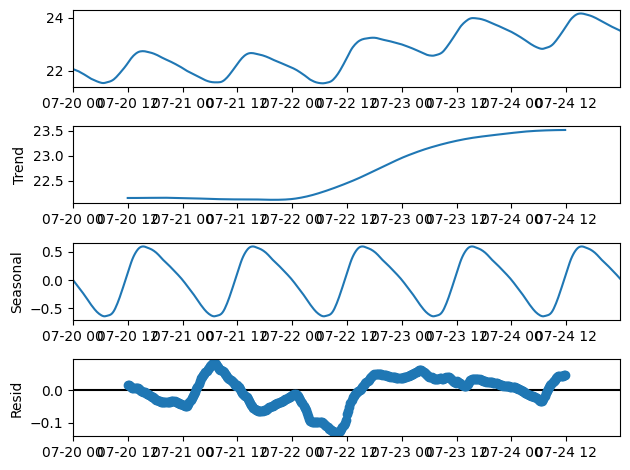

In [49]:
results = seasonal_decompose(df00,model='additive', period=period)
results.plot();

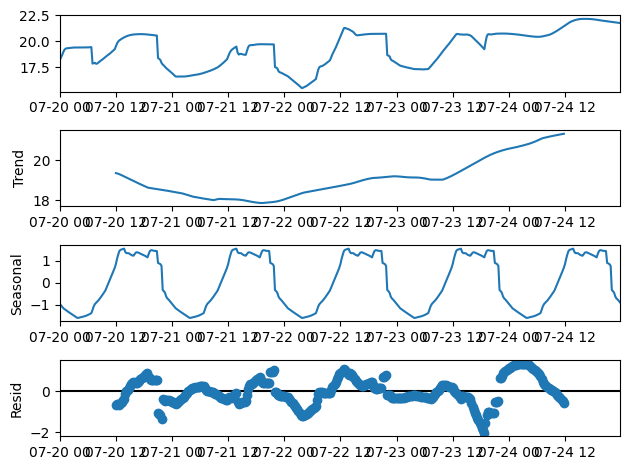

In [36]:
results01 = seasonal_decompose(df01,model='additive', period=period)
results01.plot();

In [69]:
import numpy as np

In [79]:
x = np.array(results.trend - results01.trend)

x = x[~np.isnan(x)]
x.shape


(384,)

In [82]:
def normalize(arr):
    "normalize the values in an array to be between 0 and 1 based on the minimum and maximum values in the array"
    arr2 =  (arr - arr.min())/(arr.max() - arr.min()) 
    return arr2


In [84]:
norm_trend_dif = normalize(x)

## comparing 

### seasonality vs observation 

In [142]:
fig = go.Figure()


fig.add_trace(go.Scatter(
                    x=results.seasonal.index,
                    y=normalize(results.seasonal), 
                    mode='lines',
                    name="No Open, Normalized Seasonal "
                ))
fig.add_trace(go.Scatter(
                    x=results.observed.index,
                    y=normalize(results01.observed), 
                    mode='lines',
                    name="Variable Open, Normalized Observation"
                ))

dif =normalize(results.seasonal) - normalize(results01.observed)
dif_n = normalize(dif)
fig.add_trace(go.Scatter(
                    x=results.seasonal.index,
                    y=dif, 
                    mode='lines',
                    name="Difference"
                ))

fig.add_trace(go.Scatter(
                    x=results.seasonal.index,
                    y=dif_n , 
                    mode='lines',
                    name="Normalized Difference"
                ))

fig.add_trace(go.Scatter(
                    x=t01.data["WestWindow"].datetimes,
                    y=t01.data["WestWindow"].values, 
                    mode='lines',
                    name="Window Opening"
                ))

# calculate "derivative"
deriv = pd.Series(np.gradient(dif_n.values), dif_n.index, name='deriv')

fig.add_trace(go.Scatter(
                    x=deriv.index,
                    y=deriv.values, 
                    mode='lines',
                    name="Derivative of Normalized Difference"
                ))

fig.add_trace(go.Scatter(
                    x=deriv.index,
                    y=normalize(deriv.values), 
                    mode='lines',
                    name="Normalized Derivative of Normalized Difference"
                ))

# calculate second "derivative"
deriv_2 = pd.Series(np.gradient(deriv.values), deriv.index, name='deriv_2')

fig.add_trace(go.Scatter(
                    x=deriv_2.index,
                    y=normalize(deriv_2.values), 
                    mode='lines',
                    name="Second Derivative"
                ))

deriv_wo = pd.Series(np.gradient(t01.data["WestWindow"].values), t01.data["WestWindow"].datetimes, name='deriv_wo').round(1)

fig.add_trace(go.Scatter(
                    x=deriv_wo.index,
                    y=deriv_wo.values, 
                    mode='lines',
                    name="Window Opening Derivative"
                ))



#### anomaly detection for derivative

In [173]:
deriv_df = pd.DataFrame(deriv)
deriv_df

,deriv
2017-07-20 00:00:00,-0.050498
2017-07-20 00:15:00,-0.046461
2017-07-20 00:30:00,-0.047311
2017-07-20 00:45:00,-0.047810
2017-07-20 01:00:00,-0.036351
...,...
2017-07-24 22:45:00,-0.012190
2017-07-24 23:00:00,-0.012310
2017-07-24 23:15:00,-0.012500
2017-07-24 23:30:00,-0.012801


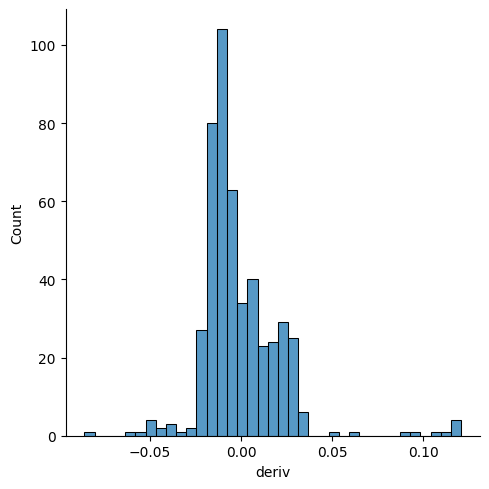

In [177]:
# look at prbability distributions...
sns.displot(deriv_df, x="deriv")

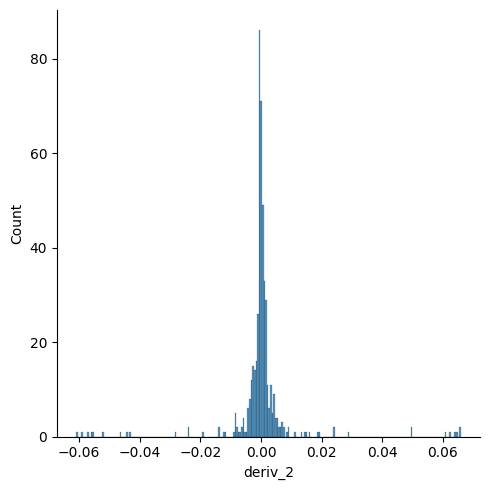

In [193]:
# look at prbability distributions...
deriv2_df = pd.DataFrame(deriv_2)
deriv2_df

sns.displot(deriv2_df, x="deriv_2")

In [179]:
deriv_df.mean()
deriv_df.std()

deriv    0.022322
dtype: float64

In [186]:
def calc_zscore(df, array):
    mean = df.mean()
    std = df.std()
    z_scores = [(x - mean)/std for x in array]
    return z_scores

In [197]:
zs = calc_zscore(deriv_df["deriv"], list(deriv_df["deriv"]))
zs2 = calc_zscore(deriv_2, list(deriv_2))


In [198]:
deriv2_df["zscore"] = zs2

In [195]:
fig = go.Figure(data=[go.Histogram(x=zs2)])
fig.show()

In [202]:
# get times where zscore > 0.8
guesses = deriv2_df.index[deriv2_df["zscore"] > 1].tolist()
guesses

[Timestamp('2017-07-20 06:30:00'),
 Timestamp('2017-07-20 06:45:00'),
 Timestamp('2017-07-20 20:30:00'),
 Timestamp('2017-07-20 20:45:00'),
 Timestamp('2017-07-21 13:30:00'),
 Timestamp('2017-07-21 13:45:00'),
 Timestamp('2017-07-21 16:15:00'),
 Timestamp('2017-07-21 16:30:00'),
 Timestamp('2017-07-21 21:30:00'),
 Timestamp('2017-07-21 21:45:00'),
 Timestamp('2017-07-22 07:15:00'),
 Timestamp('2017-07-22 07:30:00'),
 Timestamp('2017-07-22 12:45:00'),
 Timestamp('2017-07-22 21:30:00'),
 Timestamp('2017-07-22 21:45:00'),
 Timestamp('2017-07-23 19:15:00'),
 Timestamp('2017-07-23 19:30:00')]

In [205]:
deriv2_df[guesses]

KeyError: "None of [DatetimeIndex(['2017-07-20 06:30:00', '2017-07-20 06:45:00',\n               '2017-07-20 20:30:00', '2017-07-20 20:45:00',\n               '2017-07-21 13:30:00', '2017-07-21 13:45:00',\n               '2017-07-21 16:15:00', '2017-07-21 16:30:00',\n               '2017-07-21 21:30:00', '2017-07-21 21:45:00',\n               '2017-07-22 07:15:00', '2017-07-22 07:30:00',\n               '2017-07-22 12:45:00', '2017-07-22 21:30:00',\n               '2017-07-22 21:45:00', '2017-07-23 19:15:00',\n               '2017-07-23 19:30:00'],\n              dtype='datetime64[ns]', freq=None)] are in the [columns]"

In [204]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=deriv.index,
                    y=normalize(deriv.values), 
                    mode='lines',
                    name="Normalized Derivative of Normalized Difference"
                ))
fig.add_trace(go.Scatter(
                    x=t01.data["WestWindow"].datetimes,
                    y=t01.data["WestWindow"].values, 
                    mode='lines',
                    name="Window Opening"
                ))
fig.add_trace(go.Scatter(
                    x=guesses,
                    y=len(guesses)*[1], 
                    mode='markers',
                    name="Guess"
                ))

#### derivative analysis 

In [196]:
df_dwo= pd.DataFrame(deriv_wo)
a = deriv_wo.index[df_dwo["deriv_wo"] == 0.5].tolist()
b = deriv_wo.index[df_dwo["deriv_wo"] == -0.5].tolist()
wo_times = a + b

In [161]:


fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=results.seasonal.index,
                    y=normalize(results.seasonal), 
                    mode='lines',
                    name="Normalized Seasonal"
                ))
fig.add_trace(go.Scatter(
                    x=t01.data["Out"].datetimes,
                    y=normalize(np.array(t01.data["Out"].values)), 
                    mode='lines',
                    name="Outdoor Temp"
                ))

out_dif = normalize(normalize(results.seasonal) - normalize(np.array(t01.data["Out"].values)))
fig.add_trace(go.Scatter(
                    x=t01.data["Out"].datetimes,
                    y=out_dif, 
                    mode='lines',
                    name="Difference"
                ))


In [164]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=pd.to_datetime(t01.data["Out"].datetimes).hour,
                    y=out_dif, 
                    mode='markers',
                    name="Difference"
                ))

fig.update_layout(xaxis_title='Hours',
                  yaxis_title='Out Temp - Seasonality, Norm',)


In [151]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=pd.to_datetime(wo_times).hour,
                    y=normalize(deriv[wo_times].values), 
                    mode='markers',
                    name="Normalized Derivative of Normalized Difference"
                ))

fig.update_layout(xaxis_title='Hours',
                  yaxis_title='Normalized Derivative of Normalized Difference',)

In [166]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x= out_dif[wo_times],
                    y=normalize(deriv[wo_times].values),
                    mode='markers',
                    name="Normalized Derivative of Normalized Difference"
                ))

fig.update_layout(xaxis_title='Out Temp - Seasonality, Norm',
                  yaxis_title='Normalized Derivative of Normalized Difference',)

In [117]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=deriv.index.hour,
                    y=normalize(deriv.values), 
                    mode='markers',
                    name="Normalized Derivative of Normalized Difference"
                ))

fig.update_layout(xaxis_title='Hours',
                  yaxis_title='Normalized Derivative of Normalized Difference',)

In [115]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=deriv.index.hour,
                    y=deriv.values, 
                    mode='markers',
                    name="Normalized Derivative of Normalized Difference"
                ))

### trend

In [85]:
# trend 
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=results.trend.index,
                    y=results.trend, 
                    mode='lines',
                    name="No Open"
                ))
fig.add_trace(go.Scatter(
                    x=results.trend.index,
                    y=results01.trend, 
                    mode='lines',
                    name="Variable Open"
                ))

fig.add_trace(go.Scatter(
                    x=results.trend.index,
                    y=results.trend - results01.trend, 
                    mode='lines',
                    name="Difference"
                ))

fig.add_trace(go.Scatter(
                    x=results.trend.index,
                    y=norm_trend_dif , 
                    mode='lines',
                    name="Normalized Difference"
                ))
fig.add_trace(go.Scatter(
                    x=t01.data["WestWindow"].datetimes,
                    y=t01.data["WestWindow"].values, 
                    mode='lines',
                    name="Window Opening"
                ))

                